In [30]:
from massspecgym.data.datasets import MSnDataset
from massspecgym.data.transforms import MolFingerprinter
from massspecgym.featurize import SpectrumFeaturizer

import matplotlib.pyplot as plt
import seaborn as sns
from massspecgym.tools.io import load_embeddings

from scipy.stats import spearmanr


import pandas as pd
from math import comb
import numpy as np

from matchms import Spectrum

from typing import Optional
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

from typing import List, Dict, Tuple, Optional, Union
from massspecgym.tools.metrics import dreams_embedding_similarity, compute_cosine_greedy_score, compute_cosine_hungarian_score

In [31]:

def plot_distributions(data_list, labels, title="Distributions Comparison"):
    """
    Plot distributions of multiple datasets over each other.
    
    Parameters:
        data_list (list of lists): A list containing multiple datasets to plot.
        labels (list of str): A list of labels for each dataset.
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Ensure inputs are valid
    if not all(isinstance(data, list) or isinstance(data, np.ndarray) for data in data_list):
        raise ValueError("All elements in data_list must be lists or numpy arrays.")
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")
    
    # Preprocess data: Convert all elements to float
    processed_data = []
    for data in data_list:
        try:
            processed_data.append([float(x) for x in data])
        except ValueError as e:
            raise ValueError(f"One of the datasets contains non-numeric values: {e}")
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Plot each dataset as a KDE
    for data, label in zip(processed_data, labels):
        sns.kdeplot(data, label=label, fill=True, alpha=0.5, linewidth=2)
    
    # Add title and labels
    plt.title(title, fontsize=16)
    plt.xlabel("Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    
    # Add legend
    plt.legend(title="Datasets", fontsize=12, title_fontsize=14)
    
    # Show the plot
    plt.tight_layout()
    plt.show()


def compute_tanimoto_similarity(
    smiles_pairs: List[Tuple[Optional[str], Optional[str]]]
) -> List[Optional[float]]:
    """
    Compute Tanimoto similarity scores for a list of SMILES pairs.

    Parameters:
        smiles_pairs (List[Tuple[Optional[str], Optional[str]]]):
            A list of tuples, each containing two SMILES strings. 
            SMILES strings can be None or invalid.

    Returns:
        List[Optional[float]]:
            A list of Tanimoto similarity scores corresponding to each SMILES pair.
            If either SMILES in a pair is invalid or None, the corresponding score is set to None.
    """
    tanimoto_scores = []
    for idx, (smiles1, smiles2) in enumerate(smiles_pairs):
        if smiles1 is None or smiles2 is None:
            # If either SMILES is missing, append None
            tanimoto_scores.append(None)
            continue
        
        # Convert SMILES to RDKit Mol objects
        mol1 = Chem.MolFromSmiles(smiles1)
        mol2 = Chem.MolFromSmiles(smiles2)
        
        if mol1 is None or mol2 is None:
            # If conversion fails, append None
            tanimoto_scores.append(None)
            continue
        
        # Generate Morgan fingerprints
        fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)
        
        # Compute Tanimoto similarity
        similarity = DataStructs.TanimotoSimilarity(fp1, fp2)
        tanimoto_scores.append(similarity)
    
    return tanimoto_scores

# ------------------------------------------------------------------------
# 1. Spearman correlations with Tanimoto
# ------------------------------------------------------------------------
def compute_spearman_correlations(
    ms2_sims_hung, hung_tanimoto_similarities,
    ms2_sims_dreams, dreams_tanimoto_similarities
):
    """
    Compute Spearman correlation for:
      - (ms2_sims_hung, hung_tanimoto_similarities)
      - (ms2_sims_dreams, dreams_tanimoto_similarities)

    Returns:
      spearman_hung: (correlation, p_value)
      spearman_dreams: (correlation, p_value)
    """
    spearman_hung = spearmanr(ms2_sims_hung, hung_tanimoto_similarities)
    spearman_dreams = spearmanr(ms2_sims_dreams, dreams_tanimoto_similarities)
    
    return spearman_hung, spearman_dreams

# ------------------------------------------------------------------------
# 2. Bootstrap test for difference in Spearman correlations
# ------------------------------------------------------------------------
def bootstrap_spearman_diff_paired(
    ms2_sims_hung, hung_tanimoto_similarities,
    ms2_sims_dreams, dreams_tanimoto_similarities,
    n_bootstrap=1000,
    random_seed=42
):
    """
    Paired bootstrap comparison of:
      Spearman(hung, tanimoto) vs. Spearman(dreams, tanimoto).
    We assume ms2_sims_hung and ms2_sims_dreams are same-length arrays
    in matching order (i.e. each index represents the same SMILES pair).
    """
    rng = np.random.default_rng(random_seed)

    # Convert to arrays
    ms2_sims_hung = np.array(ms2_sims_hung)
    hung_tanimoto_similarities = np.array(hung_tanimoto_similarities)
    ms2_sims_dreams = np.array(ms2_sims_dreams)
    dreams_tanimoto_similarities = np.array(dreams_tanimoto_similarities)

    # We assume same length
    n_samples = 1000
    
    # Observed correlations
    corr_hung_obs, _ = spearmanr(ms2_sims_hung, hung_tanimoto_similarities)
    corr_dreams_obs, _ = spearmanr(ms2_sims_dreams, dreams_tanimoto_similarities)
    diff_observed = corr_hung_obs - corr_dreams_obs

    # Bootstrap
    diffs = []
    for _ in range(n_bootstrap):
        # Sample with replacement the *same* indices for HUNG & DREAMS
        indices = rng.integers(0, n_samples, size=n_samples)

        corr_hung_boot, _ = spearmanr(ms2_sims_hung[indices],
                                      hung_tanimoto_similarities[indices])
        corr_dreams_boot, _ = spearmanr(ms2_sims_dreams[indices],
                                        dreams_tanimoto_similarities[indices])

        diffs.append(corr_hung_boot - corr_dreams_boot)

    diffs = np.array(diffs)

    # Two-sided p-value: fraction of |diff| >= |diff_observed|
    p_value = np.mean(np.abs(diffs) >= np.abs(diff_observed))

    return diff_observed, p_value, diffs



In [32]:


def get_spectrum(node) -> Optional[Spectrum]:
    """Return the matchms.Spectrum from a node."""
    if node is None or node.spectrum is None:
        return None
    return node.spectrum

def get_embedding_for_node(node, embeddings_dict: Dict[str, np.ndarray]) -> Optional[np.ndarray]:
    """Return embedding from a dictionary that maps identifier->embedding."""
    if node is None or node.spectrum is None:
        return None
    identifier = node.spectrum.get('identifier', None)
    if identifier is None:
        return None
    return embeddings_dict.get(identifier, None)

def get_ms_level(node) -> Optional[int]:
    """Return the ms_level from node's spectrum metadata if present."""
    if node is None or node.spectrum is None:
        return None
    ms_level_str = node.spectrum.get('ms_level', None)
    if ms_level_str is not None:
        return int(ms_level_str)
    return None



def compute_tanimoto_similarity_pair(smiles1: str, smiles2: str) -> Optional[float]:
    """
    Compute Tanimoto similarity between two SMILES strings using Morgan fingerprints.

    Parameters:
        smiles1 (str): SMILES string of the first molecule.
        smiles2 (str): SMILES string of the second molecule.

    Returns:
        Optional[float]: Tanimoto similarity score between 0 and 1, or None if invalid SMILES.
    """
    if not smiles1 or not smiles2:
        return None
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is None or mol2 is None:
        return None
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)
    tanimoto = DataStructs.TanimotoSimilarity(fp1, fp2)
    return tanimoto

from typing import List, Tuple, Optional, Dict
from collections import deque
import random

def sample_pairs_with_tanimoto_bins(
    nodes_at_level: List,
    num_bins: int = 10,
    samples_per_bin: int = 100,
    max_attempts: int = 10000000
) :
    """
    Sample pairs of nodes ensuring each Tanimoto similarity bin has up to a specified number of pairs.

    Parameters:
        nodes_at_level (List): List of nodes at the target level.
        num_bins (int): Number of Tanimoto similarity bins (default is 10).
        samples_per_bin (int): Number of pairs to sample per bin (default is 100).
        max_attempts (int): Maximum number of attempts to find valid pairs (default is 100000).

    Returns:
        List[Tuple[Node, Node]]: List of tuples, each containing two nodes.
    """
    # Initialize bins
    print(len(nodes_at_level))
    bins = {i: [] for i in range(num_bins)}  # 0 to num_bins-1
    target_total = num_bins * samples_per_bin
    pairs = []
    seen = set()
    attempts = 0

    while len(pairs) < target_total and attempts < max_attempts:
        i, j = random.sample(range(len(nodes_at_level)), 2)
        sorted_pair = tuple(sorted((i, j)))
        if sorted_pair in seen:
            attempts += 1
            continue
        seen.add(sorted_pair)

        nodeA, nodeB = nodes_at_level[sorted_pair[0]], nodes_at_level[sorted_pair[1]]
        smilesA = nodeA.spectrum.get('smiles', None)
        smilesB = nodeB.spectrum.get('smiles', None)

        if smilesA is None or smilesB is None:
            attempts += 1
            continue

        tanimoto = compute_tanimoto_similarity(smilesA, smilesB)
        if tanimoto is None:
            attempts += 1
            continue

        # Determine bin index
        bin_index = int(tanimoto * num_bins)
        if bin_index == num_bins:
            bin_index = num_bins - 1  # Ensure 1.0 falls into the last bin

        if len(bins[bin_index]) < samples_per_bin:
            bins[bin_index].append((nodeA, nodeB))
            pairs.append((nodeA, nodeB))
        attempts += 1

    print(attempts)

    return pairs



def compute_same_level_similarity_limited(
    msn_dataset,
    target_level: int = 2,
    use_embedding: bool = False,
    sim_fn=None,
    embeddings_dict: Optional[Dict[str, np.ndarray]] = None,
    tolerance: float = 0.1,
    max_pairs: int = 5000,
    compute_all_metrics: bool = False,
    pair_generator: Optional[callable] = None  # New parameter
) -> Union[
    Tuple[List[float], List[Tuple[Optional[str], Optional[str]]]],
    Tuple[List[float], List[float], List[Tuple[Optional[str], Optional[str]]]]
]:
    """
    Collect *all* nodes from ALL trees with ms_level == target_level,
    then compute pairwise similarity among them (excluding node with itself).

    If the number of total pairs is small enough (< max_pairs), do them all.
    Otherwise, use the provided pair generator to sample pairs.

    If use_embedding=False, we interpret sim_fn as (specA, specB)->(score, matched_peaks).
      If sim_fn is None => default CosineGreedy(tol=0.1).
    If use_embedding=True, we interpret sim_fn as (embA, embB)->float.
      If sim_fn is None => default dreams_embedding_similarity.

    If compute_all_metrics=True, compute both cosine similarity on spectra and embeddings
    for each pair. Requires sim_fn and embeddings_dict to be provided.

    Additionally, for each computed similarity, retrieve the corresponding SMILES pairs.

    Parameters:
        msn_dataset: The dataset containing trees of nodes with spectra and embeddings.
        target_level (int): The specific depth level in the tree to collect nodes from.
        use_embedding (bool): Whether to compute similarity based on embeddings or spectra.
        sim_fn: The similarity function to use. If None, defaults are applied based on use_embedding.
        embeddings_dict (Optional[Dict[str, np.ndarray]]): Dictionary mapping identifiers to embeddings.
        tolerance (float): Tolerance parameter for the default CosineGreedy similarity function.
        max_pairs (int): Maximum number of similarity pairs to compute.
        compute_all_metrics (bool): Whether to compute both cosine similarities on spectra and embeddings.
        pair_generator (Optional[callable]): Function to generate pairs. If provided, it should accept
                                             nodes_at_level as input and return a list of node pairs.

    Returns:
        - If compute_all_metrics=False:
            Tuple[List[float], List[Tuple[Optional[str], Optional[str]]]]:
                - List of similarity scores.
                - List of tuples containing SMILES pairs corresponding to each similarity score.
        - If compute_all_metrics=True:
            Tuple[List[float], List[float], List[Tuple[Optional[str], Optional[str]]]]:
                - List of cosine similarity scores based on spectra.
                - List of cosine similarity scores based on embeddings.
                - List of tuples containing SMILES pairs corresponding to each similarity score.
    """

    # 1) Gather nodes at target_level
    nodes_at_level = []
    for tree in msn_dataset.trees:
        queue = deque([tree.root])
        while queue:
            node = queue.popleft()
            if node.spectrum is not None:
                lvl_str = node.spectrum.get("ms_level", None)
                if lvl_str is not None and int(lvl_str) == target_level:
                    nodes_at_level.append(node)
            for child in node.children.values():
                queue.append(child)

    n = len(nodes_at_level)
    if n < 2:
        if compute_all_metrics:
            return [], [], []
        else:
            return [], []

    # total number of pairs
    total_pairs = comb(n, 2)  # n*(n-1)//2

    # Decide if we do all pairs or use a pair generator
    if total_pairs <= max_pairs or pair_generator is None:
        if total_pairs <= max_pairs:
            # Collect all possible pairs
            pairs = []
            for i in range(n):
                for j in range(i+1, n):
                    pairs.append((nodes_at_level[i], nodes_at_level[j]))
        else:
            # Use default random sampling without bins
            pairs = []
            seen = set()
            attempts = 0
            while len(pairs) < max_pairs and attempts < max_pairs * 10:
                i, j = random.sample(range(n), 2)
                sorted_pair = tuple(sorted((i, j)))
                if sorted_pair in seen:
                    attempts += 1
                    continue
                seen.add(sorted_pair)
                pairs.append((nodes_at_level[sorted_pair[0]], nodes_at_level[sorted_pair[1]]))
                attempts += 1
    else:
        # Use the provided pair generator
        pairs = pair_generator(nodes_at_level)

    # Initialize lists to store similarity scores and SMILES pairs
    sims_spectra = []  # For cosine similarity based on spectra
    sims_embeddings = []  # For cosine similarity based on embeddings
    smiles_pairs = []

    # For each pair, compute similarity and retrieve SMILES
    for (nodeA, nodeB) in pairs:
        # Initialize similarity scores for this pair
        score_spectra = float('nan')
        score_embeddings = float('nan')

        # Compute cosine similarity on spectra if required
        if not compute_all_metrics:
            if not use_embedding:
                specA = get_spectrum(nodeA)
                specB = get_spectrum(nodeB)
                if specA is not None and specB is not None:
                    if sim_fn is None:
                        (score, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                    else:
                        (score, _) = sim_fn(specA, specB)
                    score_spectra = score
            else:
                embA = get_embedding_for_node(nodeA, embeddings_dict)
                embB = get_embedding_for_node(nodeB, embeddings_dict)
                if embA is not None and embB is not None:
                        score_embeddings = dreams_embedding_similarity(embA, embB)
        else:
            # Compute both similarities
            # 1. Cosine similarity on spectra
            specA = get_spectrum(nodeA)
            specB = get_spectrum(nodeB)
            if specA is not None and specB is not None:
                if sim_fn is None:
                    (score, _) = compute_cosine_greedy_score(specA, specB, tolerance=tolerance)
                else:
                    (score, _) = sim_fn(specA, specB)
                score_spectra = score

            # 2. Cosine similarity on embeddings
            if embeddings_dict is not None:
                embA = get_embedding_for_node(nodeA, embeddings_dict)
                embB = get_embedding_for_node(nodeB, embeddings_dict)
                if embA is not None and embB is not None:
                    score_embeddings = dreams_embedding_similarity(embA, embB)


        # Append the computed similarity scores
        if compute_all_metrics:
            sims_spectra.append(float(score_spectra))
            sims_embeddings.append(float(score_embeddings))
        else:
            if not use_embedding:
                sims_spectra.append(float(score_spectra))
            else:
                sims_embeddings.append(float(score_embeddings))

        # Retrieve SMILES from both nodes
        smilesA = nodeA.spectrum.get('smiles', None)
        smilesB = nodeB.spectrum.get('smiles', None)
        smiles_pairs.append((smilesA, smilesB))

    # Return based on compute_all_metrics
    if compute_all_metrics:
        return sims_spectra, sims_embeddings, smiles_pairs
    else:
        if not use_embedding:
            return sims_spectra, smiles_pairs
        else:
            return sims_embeddings, smiles_pairs
        
def generate_tanimoto_binned_pairs(nodes_at_level: List, num_bins: int = 7, samples_per_bin: int = 50):
    """
    Wrapper function to generate pairs with Tanimoto similarity bins.
    """
    return sample_pairs_with_tanimoto_bins(
        nodes_at_level=nodes_at_level,
        num_bins=num_bins,
        samples_per_bin=samples_per_bin
    )
def compute_tanimoto_similarities(smiles_pairs: List[Tuple[str, str]]) -> List[Optional[float]]:
    """
    Compute Tanimoto similarity for each pair of SMILES in smiles_pairs.
    """
    return [compute_tanimoto_similarity(smiles1, smiles2) for smiles1, smiles2 in smiles_pairs]


In [33]:
# For similarity function (hungarian_fn)
def hungarian_fn(specA, specB):
    (sc, _) = compute_cosine_hungarian_score(specA, specB, tolerance=0.1)
    return (sc, 0)

In [6]:
file_mgf = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_msn_library_pos_all_lib_MSn.mgf"
split_file = "/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/20241211_split.tsv"

In [7]:
embeddings_dict = load_embeddings(
    file_path="/Users/macbook/CODE/Majer:MassSpecGym/data/MSn/MSn_DreaMS.h5",
    identifier_col="identifiers",
    embedding_col="embeddings"
)

In [8]:
config = {
    'features': ['binned_peaks'],
    'feature_attributes': {
        'binned_peaks': {
            'max_mz': 1,
            'bin_width': 1.0,
        },
    },
}

featurizer = SpectrumFeaturizer(config, mode='torch')

In [9]:
# Init hyperparameters
n_peaks = 60
fp_size = 4096
batch_size = 12

msn_dataset = MSnDataset(
    pth=file_mgf,
    featurizer=featurizer,
    mol_transform=MolFingerprinter(fp_size=fp_size),
    max_allowed_deviation=0.005
)

In [56]:
ms2_sims_hung, ms2_sims_dreams, smiles_pairs = compute_same_level_similarity_limited(
    msn_dataset=msn_dataset,
    target_level=2,
    use_embedding=False,          
    sim_fn=hungarian_fn,                 
    embeddings_dict=embeddings_dict, 
    tolerance=0.1,
    max_pairs=25000000,
    compute_all_metrics=True
)

In [57]:
tanimoto_similarities = compute_tanimoto_similarity(smiles_pairs)

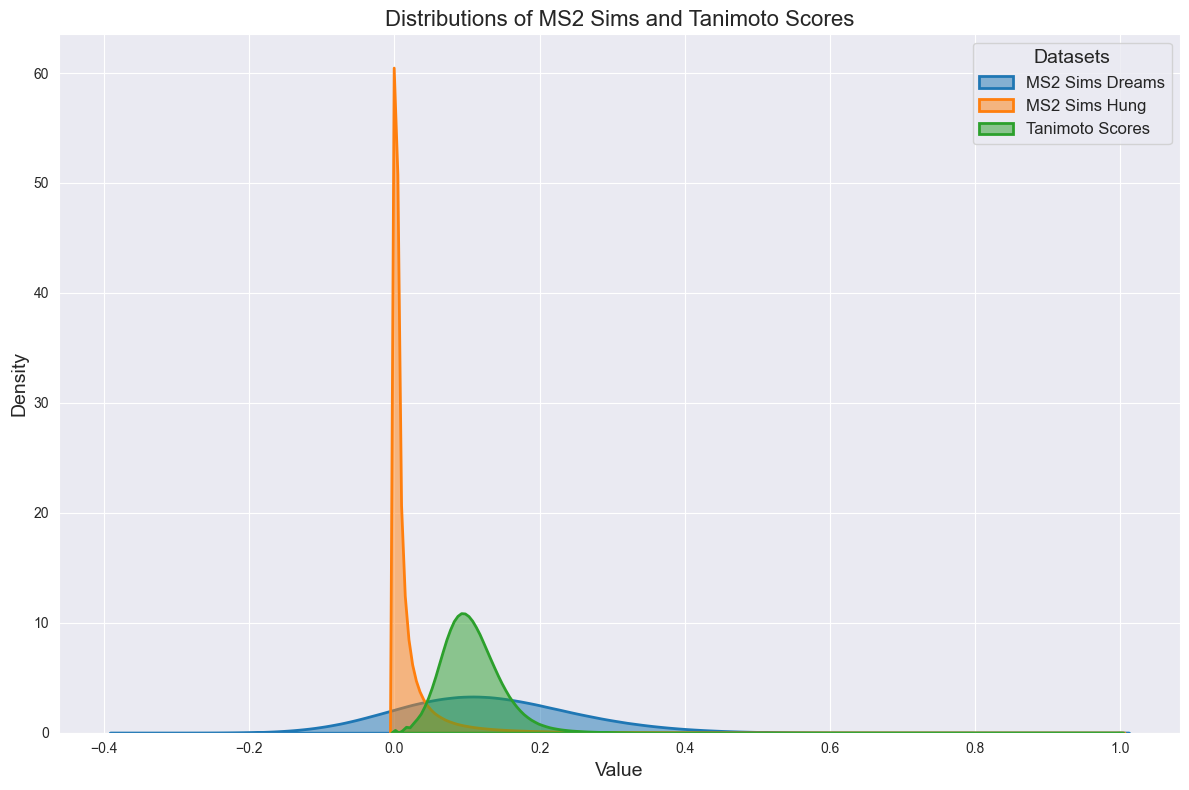

In [58]:
plot_distributions(
    data_list=[ms2_sims_dreams, ms2_sims_hung, tanimoto_similarities],
    labels=["MS2 Sims Dreams", "MS2 Sims Hung", "Tanimoto Scores"],
    title="Distributions of MS2 Sims and Tanimoto Scores"
)

In [59]:
df = pd.DataFrame({
    "Tanimoto": tanimoto_similarities,
    "HUNG_Spectral": ms2_sims_hung,
    "DREAMS_Embedding": ms2_sims_dreams
})

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


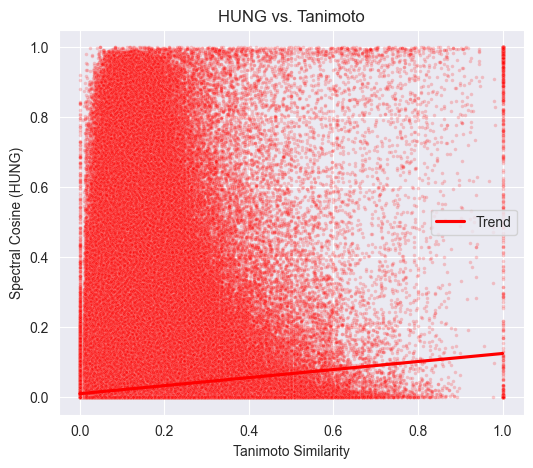

In [60]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x="Tanimoto", y="HUNG_Spectral", data=df, alpha=0.2, s=6.6, color="red")
sns.regplot(x="Tanimoto", y="HUNG_Spectral", data=df, 
            scatter=False, color="red", ci=None, label="Trend")
plt.title("HUNG vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Spectral Cosine (HUNG)")
plt.legend()
plt.show()

/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


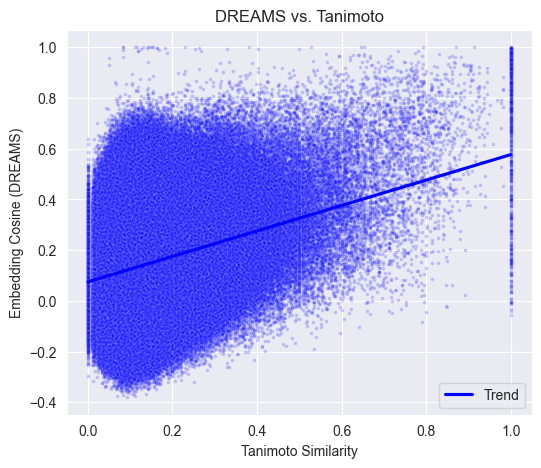

In [61]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x="Tanimoto", y="DREAMS_Embedding", data=df, alpha=0.2, s=6.6, color="blue")
sns.regplot(x="Tanimoto", y="DREAMS_Embedding", data=df, 
            scatter=False, color="blue", ci=None, label="Trend")
plt.title("DREAMS vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Embedding Cosine (DREAMS)")
plt.legend()
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34763/1916029521.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby("Tanimoto_bin").agg({


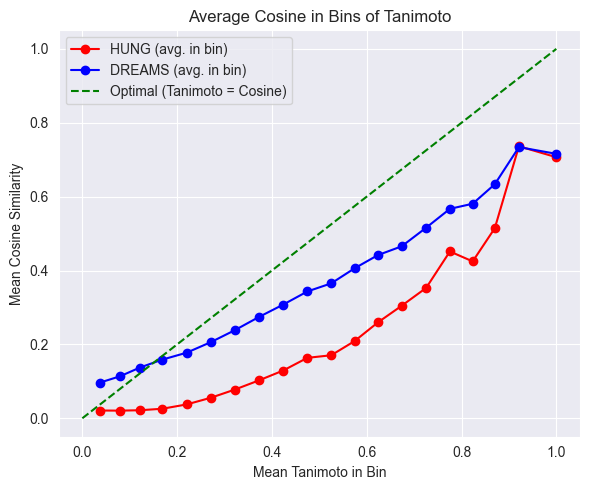

In [62]:
# Discretize Tanimoto into bins
df["Tanimoto_bin"] = pd.cut(df["Tanimoto"], bins=np.linspace(0, 1, 21), include_lowest=True)

grouped = df.groupby("Tanimoto_bin").agg({
    "HUNG_Spectral": "mean",
    "DREAMS_Embedding": "mean",
    "Tanimoto": "mean"
}).reset_index(drop=True)

plt.figure(figsize=(6, 5))

plt.plot(grouped["Tanimoto"], grouped["HUNG_Spectral"], marker="o", color="red", label="HUNG (avg. in bin)")
plt.plot(grouped["Tanimoto"], grouped["DREAMS_Embedding"], marker="o", color="blue", label="DREAMS (avg. in bin)")

plt.plot([0, 1], [0, 1], linestyle="--", color="green", label="Optimal (Tanimoto = Cosine)")

plt.title("Average Cosine in Bins of Tanimoto")
plt.xlabel("Mean Tanimoto in Bin")
plt.ylabel("Mean Cosine Similarity")
plt.legend()

plt.tight_layout()
plt.show()

In [65]:
import pandas as pd
import numpy as np

# 1) cut into equal-width bins
n_bins = 20
df["T_bin"] = pd.cut(df["Tanimoto"], bins=n_bins, include_lowest=True)

# 2) decide how many points per bin (e.g. 2000)
samples_per_bin = 500

# 3) sample *without* replacement, so sparse bins stay small
def uniform_sample(group):
    n = len(group)
    k = min(n, samples_per_bin)        # never ask for more than you have
    return group.sample(k, replace=False)

df_balanced = (
    df
    .groupby("T_bin", group_keys=False)
    .apply(uniform_sample)
    .reset_index(drop=True)
)

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34763/1735910527.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("T_bin", group_keys=False)
/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34763/1735910527.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(uniform_sample)


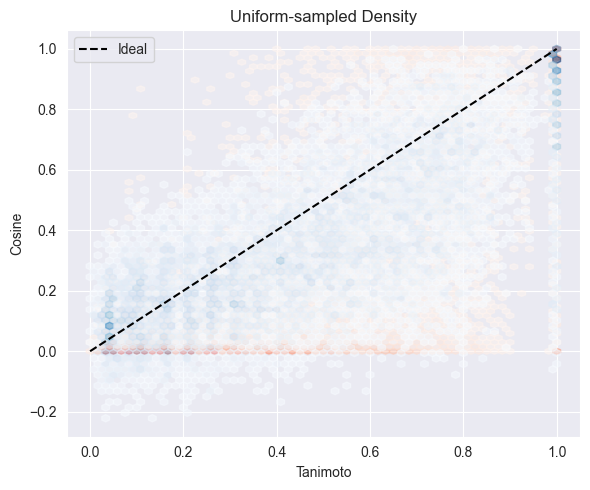

In [66]:
fig, ax = plt.subplots(figsize=(6,5))
hb1 = ax.hexbin(df_balanced["Tanimoto"], df_balanced["HUNG_Spectral"],
                gridsize=60, cmap="Reds", mincnt=1, alpha=0.5)
hb2 = ax.hexbin(df_balanced["Tanimoto"], df_balanced["DREAMS_Embedding"],
                gridsize=60, cmap="Blues", mincnt=1, alpha=0.5)
ax.plot([0,1],[0,1],"--k", label="Ideal")
ax.set(xlabel="Tanimoto", ylabel="Cosine", title="Uniform-sampled Density")
ax.legend()
plt.tight_layout()
plt.show()

/var/folders/bl/73ckjztx5js4cc0cj85qgvlm0000gn/T/ipykernel_34763/3482204969.py:31: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
/Users/macbook/UTILS/anaconda3/envs/massspecgym/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


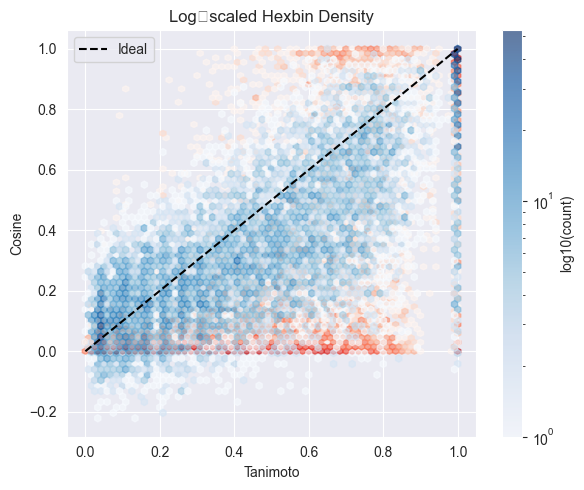

In [67]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,5))

# HUNG with log‐scaled counts
hb1 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["HUNG_Spectral"],
    gridsize=60,
    cmap="Reds",
    bins="log",      # ← map counts via log10
    mincnt=1,
    alpha=0.6
)

# DREAMS with log‐scaled counts
hb2 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["DREAMS_Embedding"],
    gridsize=60,
    cmap="Blues",
    bins="log",
    mincnt=1,
    alpha=0.6
)

ax.plot([0,1],[0,1],"--k", label="Ideal")
ax.set(xlabel="Tanimoto", ylabel="Cosine", title="Log‐scaled Hexbin Density")
ax.legend()

# One combined colorbar will now show log10(count)
cb = fig.colorbar(hb2, ax=ax, label="log10(count)")
plt.tight_layout()
plt.show()

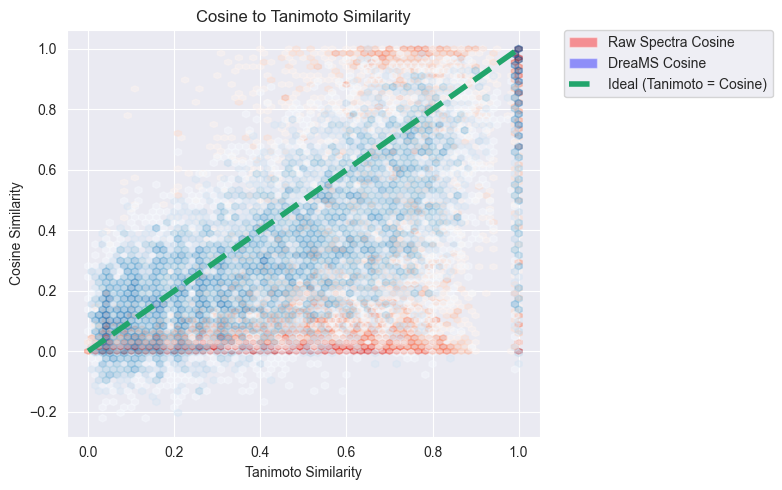

In [94]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Wider canvas so plot area stays ~6"x5"
fig, ax = plt.subplots(figsize=(8, 5))

# Raw Spectra Cosine (HUNG) in red
hb1 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["HUNG_Spectral"],
    gridsize=60, cmap="Reds", bins="log", mincnt=1,
    alpha=0.4
)

# DreaMS Embedding in blue
hb2 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["DREAMS_Embedding"],
    gridsize=60, cmap="Blues", bins="log", mincnt=1,
    alpha=0.4
)

# Thick purple solid diagonal
ideal_line, = ax.plot(
    [0, 1], [0, 1],
    linestyle="--", color="#22A56C", linewidth=4,
    label="Ideal (Tanimoto = Cosine)"
)

# Axis labels and title
ax.set(
    xlabel="Tanimoto Similarity",
    ylabel="Cosine Similarity",
    title="Cosine to Tanimoto Similarity"
)

# Legend proxies
proxy_hung   = Patch(facecolor="red",   alpha=0.4, label="Raw Spectra Cosine")
proxy_dreams = Patch(facecolor="blue",  alpha=0.4, label="DreaMS Cosine")

# Legend outside, nudged to the right
ax.legend(
    handles=[proxy_hung, proxy_dreams, ideal_line],
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

fig.savefig("hexbin_density_blue.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

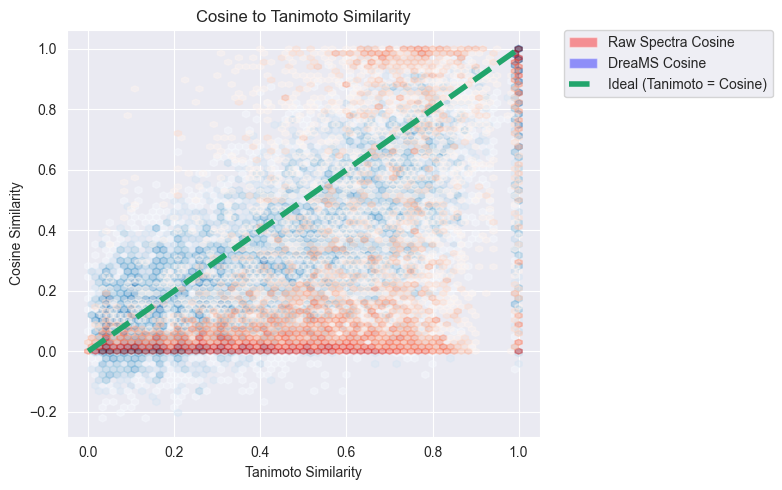

In [95]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Wider canvas so plot area stays ~6"x5"
fig, ax = plt.subplots(figsize=(8, 5))

# 1) Draw DreaMS (blue) first, zorder=1
hb2 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["DREAMS_Embedding"],
    gridsize=60, cmap="Blues", bins="log", mincnt=1,
    alpha=0.4, zorder=1
)

# 2) Draw Raw Spectra (red) on top, zorder=2
hb1 = ax.hexbin(
    df_balanced["Tanimoto"], df_balanced["HUNG_Spectral"],
    gridsize=60, cmap="Reds", bins="log", mincnt=1,
    alpha=0.4, zorder=2
)

# Thick lavender diagonal, zorder=3
ideal_line, = ax.plot(
    [0, 1], [0, 1],
    linestyle="--", color="#22A56C", linewidth=4,
    label="Ideal (Tanimoto = Cosine)",
    zorder=3
)

# Axis labels and title
ax.set(
    xlabel="Tanimoto Similarity",
    ylabel="Cosine Similarity",
    title="Cosine to Tanimoto Similarity"
)

# Legend proxies
proxy_hung   = Patch(facecolor="red",   alpha=0.4, label="Raw Spectra Cosine")
proxy_dreams = Patch(facecolor="blue",  alpha=0.4, label="DreaMS Cosine")

# Legend outside, nudged to the right
ax.legend(
    handles=[proxy_hung, proxy_dreams, ideal_line],
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0
)

fig.savefig("hexbin_density_red.png", dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()

## second tanimoto

In [24]:
tanimoto_similarities = compute_tanimoto_similarity_pair(smiles_pairs)

In [25]:
df = pd.DataFrame({
    "Tanimoto": tanimoto_similarities,
    "HUNG_Spectral": ms2_sims_hung,
    "DREAMS_Embedding": ms2_sims_dreams
})

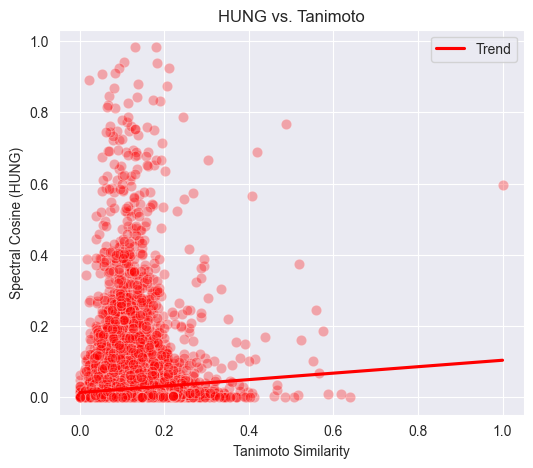

In [26]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x="Tanimoto", y="HUNG_Spectral", data=df, alpha=0.3, s=56.6, color="red")
sns.regplot(x="Tanimoto", y="HUNG_Spectral", data=df, 
            scatter=False, color="red", ci=None, label="Trend")
plt.title("HUNG vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Spectral Cosine (HUNG)")
plt.legend()
plt.show()

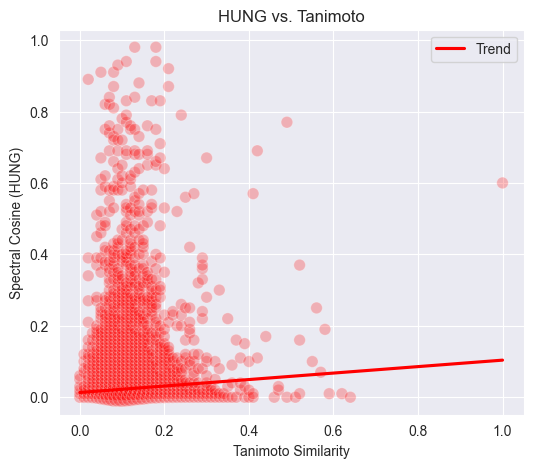

In [27]:
df_grouped = df.copy()
df_grouped['Tanimoto_rnd'] = df_grouped['Tanimoto'].round(2)
df_grouped['HUNG_Spectral_rnd'] = df_grouped['HUNG_Spectral'].round(2)

grouped = df_grouped.groupby(['Tanimoto_rnd', 'HUNG_Spectral_rnd']).size().reset_index(name='count')
grouped.rename(columns={'Tanimoto_rnd': 'Tanimoto', 'HUNG_Spectral_rnd': 'HUNG_Spectral'}, inplace=True)

plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(x='Tanimoto', y='HUNG_Spectral', data=grouped, 
                          size='count', sizes=(70, 200), legend=False, 
                          color='red', alpha=0.25)

sns.regplot(x="Tanimoto", y="HUNG_Spectral", data=df, 
            scatter=False, color="red", ci=None, label="Trend")

plt.title("HUNG vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Spectral Cosine (HUNG)")
plt.legend()
plt.show()

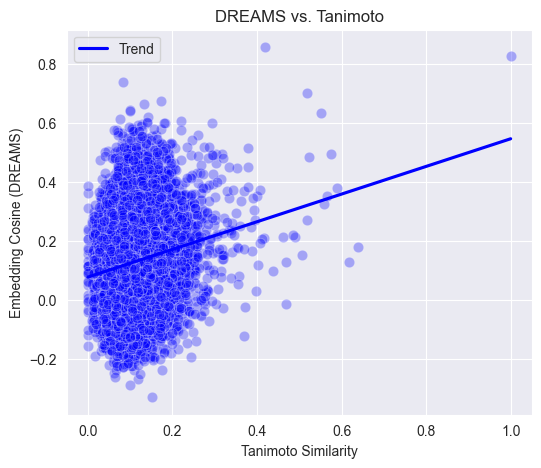

In [28]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x="Tanimoto", y="DREAMS_Embedding", data=df, alpha=0.3, s=56.6, color="blue")
sns.regplot(x="Tanimoto", y="DREAMS_Embedding", data=df, 
            scatter=False, color="blue", ci=None, label="Trend")
plt.title("DREAMS vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Embedding Cosine (DREAMS)")
plt.legend()
plt.show()

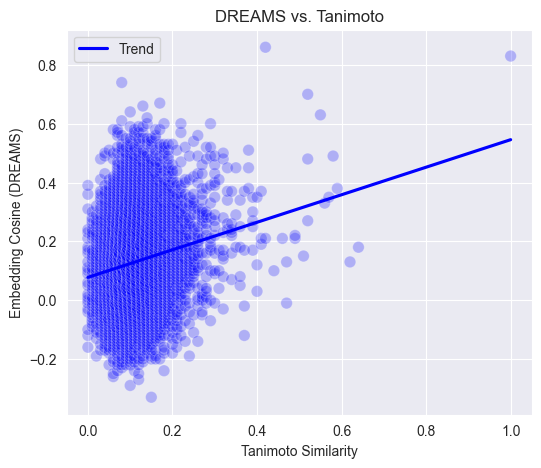

In [29]:
# Copy and round data to aggregate near-identical values for DREAMS_Embedding
df_grouped_embedding = df.copy()
# Round to 2 decimals (adjust as needed)
df_grouped_embedding['Tanimoto_rnd'] = df_grouped_embedding['Tanimoto'].round(2)
df_grouped_embedding['DREAMS_Embedding_rnd'] = df_grouped_embedding['DREAMS_Embedding'].round(2)

# Group by the rounded coordinates and count observations
grouped_embedding = df_grouped_embedding.groupby(
    ['Tanimoto_rnd', 'DREAMS_Embedding_rnd']
).size().reset_index(name='count')
grouped_embedding.rename(
    columns={'Tanimoto_rnd': 'Tanimoto', 'DREAMS_Embedding_rnd': 'DREAMS_Embedding'},
    inplace=True
)

# Plotting: use the aggregated counts to set marker sizes in the scatter plot.
plt.figure(figsize=(6, 5))
scatter = sns.scatterplot(
    x='Tanimoto',
    y='DREAMS_Embedding',
    data=grouped_embedding,
    size='count',
    sizes=(70, 200),
    legend=False,
    color='blue',
    alpha=0.25
)

# Overlay the regression trend line computed on the original data
sns.regplot(
    x="Tanimoto",
    y="DREAMS_Embedding",
    data=df,
    scatter=False,
    color="blue",
    ci=None,
    label="Trend"
)

plt.title("DREAMS vs. Tanimoto")
plt.xlabel("Tanimoto Similarity")
plt.ylabel("Embedding Cosine (DREAMS)")
plt.legend()
plt.show()